In [1]:
# various import statements
import os
import sklearn
from sklearn import cluster
import pandas as pd
import scanpy as sc
import scvi
import inspect
import tqdm
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim
from pyro.infer import SVI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

sc.settings.figdir=os.path.expanduser('~/WbFigures/SpeciesDivergenceNoScaling')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


cuda:0


In [2]:
 
if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


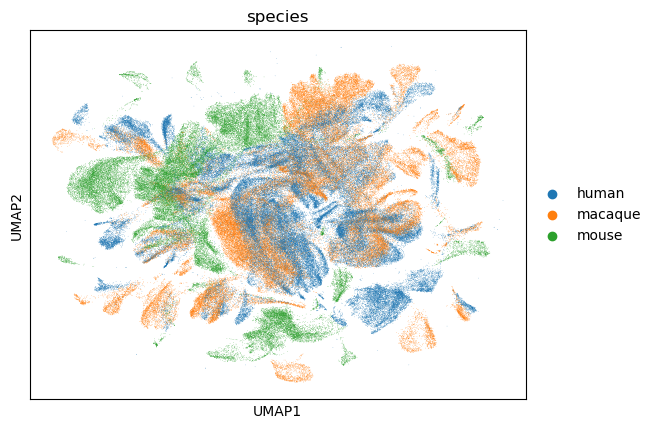

In [3]:
#adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall.h5ad'),backed='r')
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_part0.h5ad'),backed='r')

adata.obsm["X_original_umap"]=adata.obsm["X_umap"]
sc.pl.umap(adata,color='species')

In [4]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/')
import antipode_model
from antipode_model import *
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import model_modules
from model_modules import *
import train_utils
from train_utils import *
import plotting
from plotting import *

import importlib
antipode_model=importlib.reload(antipode_model)
from antipode_model import *

model_modules=importlib.reload(model_modules)
from model_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

model_distributions=importlib.reload(model_distributions)
from model_distributions import *

train_utils=importlib.reload(train_utils)
from train_utils import *

plotting=importlib.reload(plotting)
from plotting import *



In [5]:
#Derived from version PBS1.9.1.6
import sklearn
from sklearn import cluster
import pandas as pd
import scanpy as sc
import anndata
import scvi
import inspect
import tqdm
import numpy as np
import scipy
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim
import re
from scvi.module.base import PyroBaseModuleClass

from model_modules import *
from model_distributions import *
from model_functions import *
from train_utils import *
from plotting import *

class AntipodeTrainingMixin:
    '''
    Mixin class providing functions to actually run ANTIPODE.
    The naive model trains in 3 phases, first a nonhierarchical block phase to estimate cell type manifolds, then phase 2 learns parameters for a fixed discrete clustering on a fixed latent space for initialization (or supervised). Phase 3 makes all parameters learnable.
    You can also use supervised taxonomy by providing a clustering as a discrete obsm matrix and training only phase2 with freeze_encoder=False.
    '''
    
    def save_params_to_uns(self,prefix=''):
        pstore=param_store_to_numpy()
        pstore={n:pstore[n] for n in pstore.keys() if not re.search('encoder|classifier|be_nn|\$\$\$',n)}
        self.adata_manager.adata.uns[prefix+'param_store']=pstore

    def get_antipode_outputs(self,batch_size=2048,device='cuda'):
        if 'discov_onehot' not in self.adata_manager.adata.obsm.keys():
            self.adata_manager.adata.obs[self.discov_key]=self.adata_manager.adata.obs[self.discov_key].astype('category')
            self.adata_manager.adata.obsm['discov_onehot']=numpy_onehot(self.adata_manager.adata.obs[self.discov_key].cat.codes)
        self.adata_manager.register_new_fields([scvi.data.fields.ObsmField('discov_onehot','discov_onehot')])
    
        field_types={"s":np.float32,"discov_onehot":np.float32}
        dataloader=scvi.dataloaders.AnnDataLoader(self.adata_manager,batch_size=32,drop_last=False,shuffle=False,data_and_attributes=field_types)#supervised_field_types for supervised step 
        encoder_outs=batch_output_from_dataloader(dataloader,self.zl_encoder,batch_size=batch_size,device=device)
        encoder_outs[0]=self.z_transform(encoder_outs[0])
        encoder_out=[x.detach().cpu().numpy() for x in encoder_outs]
        classifier_outs=batch_torch_outputs([(self.z_transform(encoder_outs[0]))],self.classifier,batch_size=batch_size,device='cuda')
        classifier_out=[x.detach().cpu().numpy() for x in classifier_outs]
        return encoder_out,classifier_out

    def store_outputs(self,device='cuda',prefix=''):
        self.save_params_to_uns(prefix='')
        self.to('cpu')
        self.eval()
        antipode_outs=self.get_antipode_outputs(batch_size=2048,device=device)
        self.allDone()
        taxon=antipode_outs[1][0]
        self.adata_manager.adata.obsm[prefix+'X_antipode']=antipode_outs[0][0]
        self.adata_manager.adata.obs[prefix+'psi']=numpy_centered_sigmoid(antipode_outs[1][1])
        self.adata_manager.adata.obs[prefix+'q_score']=scipy.special.expit(antipode_outs[0][2])
        level_edges=[numpy_hardmax(self.adata_manager.adata.uns[prefix+'param_store']['edges_'+str(i)],axis=-1) for i in range(len(self.level_sizes)-1)]
        levels=self.tree_convergence_bottom_up.just_propagate(scipy.special.softmax(taxon[...,-self.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
        prop_taxon=np.concatenate(levels,axis=-1)
        self.adata_manager.adata.obsm[prefix+'taxon_probs']=prop_taxon
        levels=self.tree_convergence_bottom_up.just_propagate(numpy_hardmax(levels[-1],axis=-1),level_edges,s=torch.ones(1))
        for i in range(len(levels)):
            cur_clust=prefix+'level_'+str(i)
            self.adata_manager.adata.obs[cur_clust]=levels[i].argmax(1)
            self.adata_manager.adata.obs[cur_clust]=self.adata_manager.adata.obs[cur_clust].astype(str)
        self.adata_manager.adata.obs[prefix+'antipode_cluster'] = self.adata_manager.adata.obs.apply(lambda x: '_'.join([x[prefix+'level_'+str(i)] for i in range(len(levels))]), axis=1)
        self.adata_manager.adata.obs[prefix+'antipode_cluster'] = self.adata_manager.adata.obs[prefix+'antipode_cluster'].astype(str)    
    
    def pretrain_classifier(self,epochs = 5,learning_rate = 0.001,batch_size = 64,prefix='',cluster='kmeans',device='cuda'):
        '''basic pytorch training of feed forward classifier to ease step 2'''        
        self=self.train()
        
        model = self.classifier.to(device)
        input_tensor =  torch.tensor(self.adata_manager.adata.obsm[self.dimension_reduction])  # Your input features tensor, shape [n_samples, n_features]
        target_tensor = torch.tensor(self.adata_manager.adata.obsm[cluster+'_onehot'])  # Your target labels tensor, shape [n_samples]    
        
        # Step 1: Prepare to train
        dataset = torch.utils.data.TensorDataset(input_tensor, target_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        #Training loop
        for epoch in range(epochs):
            for inputs, targets in dataloader:
                # Forward pass
                outputs = model(inputs.to(device))
                loss = criterion(softmax(outputs[0],-1)[:,-targets.shape[-1]:], targets.to(device))
        
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')     

    def fix_scale_factor(self,svi,x,ideal_val=0.1):
        o1=svi.evaluate_loss(*x)
        s1=self.scale_factor
        s2=ideal_val*s1/o1
        self.scale_factor=s2

    def prepare_phase_2(self,cluster='kmeans',prefix='',epochs = 5,device='cuda',dimension_reduction='X_antipode'):
        '''Run this if not running in supervised only mode (JUST phase2 with provided obsm clustering), 
        runs kmeans if cluster=kmeans, else uses the obs column provided by cluster. epochs=None skips pretraing of classifier
        To learn a latent space from scratch set dimension_reduction to None and use freeze_encoder=False'''
        if cluster=='kmeans':
            kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=self.level_sizes[-1],init='k-means++',max_iter=1000,reassignment_ratio=0.001,n_init=100,random_state=0).fit(self.adata_manager.adata.obsm[dimension_reduction])
            self.adata_manager.adata.obs['kmeans']=kmeans.labels_
            self.adata_manager.adata.obs['kmeans']=self.adata_manager.adata.obs['kmeans'].astype(int).astype('category')
            self.adata_manager.adata.obsm['kmeans_onehot']=numpy_onehot(self.adata_manager.adata.obs['kmeans'].cat.codes,num_classes=self.level_sizes[-1])
        else:
            self.adata_manager.adata.obs[cluster]=self.adata_manager.adata.obs[cluster].astype('category')
            self.adata_manager.adata.obsm[cluster+'_onehot']=numpy_onehot(self.adata_manager.adata.obs[cluster].cat.codes,num_classes=self.level_sizes[-1])
        
        self.adata_manager.register_new_fields([make_field('taxon',('obsm',cluster+'_onehot'))])
        if dimension_reduction is not None:#For supervised Z register dr
            self.dimension_reduction=dimension_reduction
            self.adata_manager.register_new_fields([make_field('Z_obs',('obsm',dimension_reduction))])
        if (epochs is not None) and (dimension_reduction is not None):
            self.pretrain_classifier(cluster=cluster,prefix=prefix,epochs=epochs,device=device)
        kmeans_means=group_aggr_anndata(self.adata_manager.adata,[cluster], agg_func=np.mean,layer=dimension_reduction,obsm=True)[0]
        if 'locs' not in [x for x in pyro.get_param_store()]:
            print('quick init')
            self.train_phase(phase=1,max_steps=1,print_every=10000,num_particles=1,device=device, max_learning_rate=1e-10, one_cycle_lr=True, steps=0, batch_size=32)
        new_locs=torch.concatenate(
            [pyro.param('locs').new_zeros(sum(self.level_sizes[:-1]),pyro.param('locs').shape[1]),
             torch.tensor(kmeans_means-kmeans_means.mean(0),device=pyro.param('locs').device).float()],
             axis=0).float()
        new_locs[0,:]=torch.tensor(kmeans_means.mean(0)).float()
        self.adata_manager.adata.obs[cluster].astype(int)
        new_scales=group_aggr_anndata(self.adata_manager.adata,[cluster], agg_func=np.std,layer=dimension_reduction,obsm=True)[0]
        new_scales=torch.concatenate(
            [1e-5 * self.scale_init_val * new_locs.new_ones(sum(self.level_sizes[:-1]), pyro.param('locs').shape[1],requires_grad=True),
             torch.tensor(new_scales+1e-10,device=pyro.param('scales').device,requires_grad=True)],axis=0).float()
        self.adata_manager.adata.obs[cluster].astype(str)
        pyro.get_param_store().__setitem__('locs',new_locs)
        pyro.get_param_store().__setitem__('locs_dynam',new_locs.new_zeros(new_locs.shape))
        pyro.get_param_store().__setitem__('scales',new_scales)
        self.adata_manager.adata.obs[cluster]=self.adata_manager.adata.obs[cluster].astype(str)
        pyro.get_param_store().__setitem__('discov_dm',new_locs.new_zeros(pyro.param('discov_dm').shape))
        pyro.get_param_store().__setitem__('batch_dm',new_locs.new_zeros(pyro.param('batch_dm').shape))
        pyro.get_param_store().__setitem__('discov_di',new_locs.new_zeros(pyro.param('discov_di').shape))
        pyro.get_param_store().__setitem__('batch_di',new_locs.new_zeros(pyro.param('batch_di').shape))
        pyro.get_param_store().__setitem__('cluster_intercept',new_locs.new_zeros(pyro.param('cluster_intercept').shape))
    
    def common_training_loop(self, dataloader, max_steps, scheduler, svi, print_every, device, steps=0):
        self.losses = []
        pbar = tqdm.tqdm(total=max_steps, position=0)
        while steps < max_steps:
            for x in dataloader:
                x['step'] = torch.ones(1).to(device) * steps
                x = [x[k].to(device) if k in x.keys() else torch.zeros(1) for k in self.args]
                if self.scale_factor == 1.:
                    self.fix_scale_factor(svi, x)
                pbar.update(1)
                loss = svi.step(*x)
                steps += 1
                if hasattr(scheduler, 'step'):
                    scheduler.step()
                if steps >= max_steps - 1 :
                    break
                
                self.losses.append(loss)
                if steps % print_every == 0:
                    pbar.write(f"[Step {steps:02d}]  Loss: {np.mean(self.losses[-print_every:]):.5f}")
        pbar.close()
        try:
            self.allDone()
        except:
            pass

    def setup_scheduler(self, max_learning_rate, max_steps, one_cycle_lr):
        if one_cycle_lr:
            return pyro.optim.OneCycleLR({
                'max_lr': max_learning_rate,
                'total_steps': max_steps,
                'div_factor': 100,
                'optim_args': {},
                'optimizer': torch.optim.Adam
            })
        else:
            return pyro.optim.ClippedAdam({
                'lr': max_learning_rate,
                'lrd': (1 - (5e-6))
            })

    def train_phase(self, phase, max_steps, print_every=10000, device='cuda', max_learning_rate=0.001, num_particles=1, one_cycle_lr=True, steps=0, batch_size=32,freeze_encoder=None):
        self.scale_factor=1.
        freeze_encoder = True if freeze_encoder is None and phase == 2 else freeze_encoder
        freeze_encoder = False if freeze_encoder is None else  freeze_encoder
        self.set_freeze_encoder(freeze_encoder) 
        supervised_field_types=self.field_types.copy()
        supervised_fields=self.fields.copy()
        supervised_field_types["taxon"]=np.float32
        if not freeze_encoder and ("Z_obs" in [x.registry_key for x in  self.adata_manager.fields]) and phase == 2: #Running supervised D.R. (can't freeze encoder and run d.r.)
            supervised_field_types["Z_obs"]=np.float32
        field_types=self.field_types if phase != 2 else supervised_field_types
        dataloader = scvi.dataloaders.AnnDataLoader(self.adata_manager, batch_size=batch_size, drop_last=True, shuffle=True, data_and_attributes=field_types)
        scheduler = self.setup_scheduler(max_learning_rate, max_steps, one_cycle_lr)
        elbo_class = pyro.infer.JitTrace_ELBO
        elbo = elbo_class(num_particles=num_particles, strict_enumeration_warning=False)
        hide_params=[name for name in pyro.get_param_store() if re.search('encoder',name)]
        guide=self.guide if not self.freeze_encoder else poutine.block(self.guide,hide=hide_params)
        svi = SafeSVI(self.model, guide, scheduler, elbo,clip_std_multiplier=5.0)  
        self.train()
        self.zl_encoder.eval() if self.freeze_encoder else self.zl_encoder.train()
        self = self.to(device)
        self.set_approx(phase == 1)
        return self.common_training_loop(dataloader, max_steps, scheduler, svi, print_every, device, steps)
        
    def allDone(self):
        print("Finished training!")
        import IPython
        from IPython.display import Audio, display
        IPython.display.clear_output()#Make compatible with jupyter nbconvert
        display(Audio(url='https://notification-sounds.com/soundsfiles/Meditation-bell-sound.mp3', autoplay=True))

class ANTIPODE(PyroBaseModuleClass,AntipodeTrainingMixin):
    """
    ANTIPODE (Single Cell Ancestral Node Taxonomy Inference by Parcellation of Differential Expression) 
    leverages variational inference for analyzing and categorizing cell types by accounting for biological and batch covariates and discrete and continuous latent variables. This model works by simultaneously integrating evolution-inspired differential expression parcellation, taxonomy generation (clustering) and batch correction.

    Parameters:
    adata (AnnData): The single-cell dataset encapsulated in an AnnData object.
    discov_pair (tuple): Specifies the discovery covariate's key and its location ('obs' or 'obsm') in the AnnData object.
    batch_pair (tuple): Specifies the batch covariate's key and its location ('obs' or 'obsm') in the AnnData object.
    layer (str): The specific layer of the AnnData object to be analyzed.
    level_sizes (list of int): Defines the hierarchical model structure (corresponding to a layered tree) by specifying the size of each level. Make sure each layer gets progressively larger and ideally start with a single root. Defaults to [1, 10, 100].
    bi_depth (int): Tree depth (from root) for batch identity effect correction. Defaults to 2. Should be less than length of level_sizes
    num_latent (int): The number of latent dimensions to model. Defaults to 50. [DANGER]
    num_batch_embed (int): Number of embedding dimensions for batch effects. Defaults to 10. 
    scale_factor (float, optional): Factor for scaling the data normalization. Inferred from data if None. [DANGER]
    prior_scale (float): Scale for the Laplace prior distributions. Defaults to 100. [DANGER]
    dcd_prior (float, optional): Scale for discov_constitutive_de. Use this for missing genes (set to large negative value and rest 0. Zeros if None.
    use_psi (bool): Whether to utilize psi continuous variation parameter. Defaults to True.
    use_q_score (bool): Whether to use q continuous quality scores. Defaults to True.
    dist_normalize (bool): Whether to apply distance normalization. Defaults to False.
    z_transform (pytorch function): Function to be applied to latent space (Z) e.g. centered_sigmoid, sigmoid. This will mess up DE Parameter scaling.
    loc_as_param, zdw_as_param, intercept_as_param (bool): Flags for using location, Z decoder weight, and intercept as parameters instead (maximum likelihood inference instead of Laplace MAP), respectively. All default to False.
    theta_prior (float): Initial value for the inverse dispersion of the negative binomial. Defaults to 50. [DANGER]
    scale_init_val (float): Initial value for scaling parameters. Defaults to 0.01. [DANGER]
    classifier_hidden, encoder_hidden, batch_embedder_hidden (list of int): Sizes of hidden layers for the classifier, encoder and batch embedding networks, respectively.
    """

    def __init__(self, adata, discov_pair, batch_pair, layer, level_sizes=[1,10,100],
                 num_latent=50,scale_factor=None, prior_scale=100,dcd_prior=None,
                 use_psi=True,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,use_q_score=True,
                 num_batch_embed=10,theta_prior=50.,scale_init_val=0.01,bi_depth=2,dist_normalize=False,z_transform=None,
                 classifier_hidden=[3000,3000,3000],encoder_hidden=[6000,5000,3000,1000],batch_embedder_hidden=[1000,500,500]):

        pyro.clear_param_store()

        # Determine num_discov and num_batch from the AnnData object
        self.discov_loc, self.discov_key = discov_pair
        self.batch_loc, self.batch_key = batch_pair
        self.num_discov = adata.obsm[self.discov_key].shape[-1] if self.discov_loc == 'obsm' else len(adata.obs[self.discov_key].unique())
        self.num_batch = adata.obsm[self.batch_key].shape[-1] if self.batch_loc == 'obsm' else len(adata.obs[self.batch_key].unique())
        self.design_matrix = (self.discov_loc == 'obsm')
        self.layer=layer

        self._setup_adata_manager_store: dict[str, type[scvi.data.AnnDataManager]] = {}
        self.num_var = adata.layers[layer].shape[-1]
        self.num_latent = num_latent
        self.scale_factor = 1.0#scale_factor if scale_factor is not None else 2e2 / (self.num_var * num_particles * num_latent)
        self.num_batch_embed = num_batch_embed
        self.temperature = 0.1
        self.epsilon = 1e-5
        self.approx = False
        self.prior_scale = prior_scale
        self.use_psi=use_psi
        self.use_q_score=use_q_score
        self.loc_as_param=loc_as_param
        self.zdw_as_param=zdw_as_param
        self.intercept_as_param=intercept_as_param
        self.theta_prior=theta_prior
        self.scale_init_val=scale_init_val
        self.level_sizes=level_sizes
        self.num_labels=sum(level_sizes)
        self.bi_depth = bi_depth
        self.bi_depth = sum(self.level_sizes[:self.bi_depth])
        self.dist_normalize=dist_normalize

        self.dcd_prior=torch.zeros((self.num_discov,self.num_var)) if dcd_prior is None else dcd_prior#Use this for 
                
        # Initialize plates to be used during sampling
        self.var_plate=pyro.plate('var_plate',self.num_var,dim=-1)
        self.discov_plate=pyro.plate('discov_plate',self.num_discov,dim=-3)
        self.batch_plate=pyro.plate('batch_plate',self.num_batch,dim=-3)
        self.latent_plate=pyro.plate('latent_plate',self.num_latent,dim=-1)
        self.latent_plate2=pyro.plate('latent_plate2',self.num_latent,dim=-2)
        self.label_plate=pyro.plate('label_plate',self.num_labels,dim=-2)
        self.batch_embed_plate=pyro.plate('batch_embed_plate',self.num_batch_embed,dim=-3)
        self.bi_depth_plate=pyro.plate('bi_depth_plate',self.bi_depth,dim=-2)

        #Initialize MAP inference modules
        self.dm=MAPLaplaceModule(self,'discov_dm',[self.num_discov,self.num_labels,self.num_latent],[self.discov_plate,self.label_plate,self.latent_plate])
        self.bm=MAPLaplaceModule(self,'batch_dm',[self.num_batch_embed,self.num_labels,self.num_latent],[self.batch_embed_plate,self.label_plate,self.latent_plate])
        self.di=MAPLaplaceModule(self,'discov_di',[self.num_discov,self.num_labels,self.num_var],[self.discov_plate,self.label_plate,self.var_plate])
        self.bei=MAPLaplaceModule(self,'batch_di',[self.num_batch_embed,self.bi_depth,self.num_var],[self.batch_embed_plate,self.bi_depth_plate,self.var_plate])
        self.ci=MAPLaplaceModule(self,'cluster_intercept',[self.num_labels, self.num_var],[self.label_plate,self.var_plate],param_only=self.intercept_as_param)
        self.dc=MAPLaplaceModule(self,'discov_dc',[self.num_discov,self.num_latent,self.num_var],[self.discov_plate,self.latent_plate2,self.var_plate])
        self.zdw=MAPLaplaceModule(self,'z_decoder_weight',[self.num_latent,self.num_var],[self.latent_plate2,self.var_plate],init_val=((2/self.num_latent)*(torch.rand(self.num_latent,self.num_var)-0.5)),param_only=self.zdw_as_param)
        self.zl=MAPLaplaceModule(self,'locs',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=self.loc_as_param)
        self.zs=MAPHalfCauchyModule(self,'scales',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],init_val=self.scale_init_val*torch.ones(self.num_labels,self.num_latent),constraint=constraints.positive,param_only=False)
        self.zld=MAPLaplaceModule(self,'locs_dynam',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=False)
        self.qg=MAPLaplaceModule(self,'quality_genes',[1,self.num_var],[self.var_plate],param_only=False)
        
        self.tree_edges=TreeEdges(self,straight_through=False)
        self.tree_convergence=TreeConvergence(self)        
        self.tree_convergence_bottom_up=TreeConvergenceBottomUp(self)        
        self.z_transform=null_function if z_transform is None else z_transform#centered_sigmoid#torch.special.expit

        if self.design_matrix:
            fields={'s':('layers',self.layer),
            'discov_ind':('obsm',self.discov_key),
            'batch_ind':('obsm',self.batch_key)}
            field_types={"s":np.float32,"batch_ind":np.float32,"discov_ind":np.float32}
        else:
            fields={'s':('layers',self.layer),
            'discov_ind':('obs',self.discov_key),
            'batch_ind':('obs',self.batch_key)}
            field_types={"s":np.float32,"batch_ind":np.int64,"discov_ind":np.int64}

        self.fields=fields
        self.field_types=field_types
        self.setup_anndata(adata, {'discov_ind': discov_pair, 'batch_ind': batch_pair}, self.field_types)
        
        super().__init__()
        # Setup the various neural networks used in the model and guide
        self.z_decoder=ZDecoder(num_latent=self.num_latent, num_var=self.num_var, hidden_dims=[])        
        self.zl_encoder=ZLEncoder(num_var=self.num_var,hidden_dims=encoder_hidden,num_cat_input=self.num_discov,
                    outputs=[(self.num_latent,None),(self.num_latent,softplus),(1,None),(1,softplus)])
        
        self.classifier=Classifier(num_latent=self.num_latent,hidden_dims=classifier_hidden,
                    outputs=[(self.num_labels,None),(1,None),(1,softplus)])

        #Too large to exactly model gene-level batch effects for all cluster x batch
        self.be_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=batch_embedder_hidden,
                    out_dim=self.num_batch_embed)
        
        self.epsilon = 0.006
        #Initialize model in approximation mode
        self.approx=False
        self.prior_scale=prior_scale
        self.args=inspect.getfullargspec(self.model).args[1:]#skip self

    def setup_anndata(self,adata: anndata.AnnData,fields,field_types,**kwargs,):
        
        anndata_fields=[make_field(x,self.fields[x]) for x in self.fields.keys()]
        
        adata_manager = scvi.data.AnnDataManager(
            fields=anndata_fields
        )
        adata_manager.register_fields(adata, **kwargs)
        self.register_manager(adata_manager)
        if fields['discov_ind'][0]=='obsm':
            self.design_matrix=True
            if fields['batch_ind'][0]!='obsm':
                raise Exception("If discov is design matrix, batch must be as well!")

    def register_manager(self, adata_manager: scvi.data.AnnDataManager):
        adata_id = adata_manager.adata_uuid
        self._setup_adata_manager_store[adata_id] = adata_manager
        self.adata_manager=adata_manager
    
    def set_approx(self,b: bool):
        self.approx=b

    def set_freeze_encoder(self,b: bool):
        self.freeze_encoder=b
        
    def model(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1),Z_obs=torch.zeros(1)):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("antipode", self)

        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0],dim=-1)
        minibatch_plate2=pyro.plate("minibatch_plate2", s.shape[0],dim=-2)
        l = s.sum(1).unsqueeze(-1)
        
        # Scale all sample statements for numerical stability
        with poutine.scale(scale=self.scale_factor):
            # Counts parameter of NB (variance of the observation distribution)
            s_theta = pyro.param("s_inverse_dispersion", self.theta_prior * s.new_ones(self.num_var),
                               constraint=constraints.positive)
            #Weak overall histogram normalization
            discov_mul = pyro.param("discov_mul", s.new_ones(self.num_discov,1),constraint=constraints.positive) if self.dist_normalize else s.new_ones(self.num_discov)

            dcd=pyro.param("discov_constitutive_de", self.dcd_prior.to(s.device))
            level_edges=self.tree_edges.model_sample(s,approx=self.approx)
            quality_genes=self.qg.model_sample(s) if self.use_q_score else 0.
            
            with minibatch_plate:
                batch_embed=centered_sigmoid(pyro.sample('batch_embed', dist.Laplace(s.new_zeros(self.num_batch_embed),
                                self.prior_scale*s.new_ones(self.num_batch_embed),validate_args=True).to_event(1)))
                beta_prior_a=1.*s.new_ones(self.num_labels)
                beta_prior_a[0]=10. #0 block is consititutive
                if self.approx:#Bernoulli blocks approx?
                    taxon_probs = pyro.sample("taxon_probs", dist.Beta(beta_prior_a,s.new_ones(self.num_labels),validate_args=True).to_event(1))
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=0.1*s.new_ones(1),probs=taxon_probs).to_event(1))
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Dirichlet(s.new_ones(s.shape[0],self.level_sizes[-1]),validate_args=True))
                    if sum(taxon.shape) > 1:#Supervised?
                        if taxon.shape[-1]==self.num_labels:#Totally supervised?
                            pass
                        else:#Only bottom layer is supervised?
                            taxon = taxon_probs = pyro.sample("taxon", dist.OneHotCategorical(probs=taxon_probs,validate_args=True),obs=taxon)
                            taxon = self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s)
                    else:#Unsupervised
                        taxon = pyro.sample("taxon", 
                                         model_distributions.SafeAndRelaxedOneHotCategorical(temperature=self.temperature*s.new_ones(1),probs=taxon_probs,validate_args=True))                    
                        taxon = self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s)
                    taxon = torch.concat(taxon,-1)
                    taxon_probs=self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s)
                    taxon_probs=torch.cat(taxon_probs,-1)
                   
            locs=self.zl.model_sample(s,scale=fest([taxon_probs],-1))
            scales=self.zs.model_sample(s,scale=fest([taxon_probs],-1))
            locs_dynam=self.zld.model_sample(s,scale=fest([taxon_probs],-1))
            discov_dm=self.dm.model_sample(s,scale=fest([discov,taxon_probs],-1))
            discov_di=self.di.model_sample(s,scale=fest([discov,taxon_probs],-1))
            batch_dm=self.bm.model_sample(s,scale=fest([batch_embed.abs(),taxon_probs],-1))
            bei=self.bei.model_sample(s,scale=fest([batch_embed.abs(),taxon_probs[...,:self.bi_depth]],-1))
            cluster_intercept=self.ci.model_sample(s,scale=fest([taxon_probs],-1))
            
            with minibatch_plate:
                bi=torch.einsum('...bi,...ijk->...bjk',batch_embed,bei)
                bi=torch.einsum('...bj,...bjk->...bk',taxon[...,:self.bi_depth],bi)
                psi = centered_sigmoid(pyro.sample('psi',dist.Laplace(s.new_zeros(s.shape[0],1),self.prior_scale*s.new_ones(s.shape[0],1)).to_event(1)))
                psi = 0 if not self.use_psi or self.approx else psi
                q = torch.sigmoid(pyro.sample('q',dist.Logistic(s.new_zeros(s.shape[0],1),s.new_ones(s.shape[0],1)).to_event(1))) if self.use_q_score else 1.0
                this_locs=oh_index(locs,taxon)
                this_scales=oh_index(scales,taxon)
                z=pyro.sample('z_loc',dist.Laplace(this_locs,0.5*self.prior_scale*s.new_ones(s.shape[0],self.num_latent),validate_args=True).to_event(1))
                z_dist=dist.Normal(this_locs,this_scales+self.epsilon,validate_args=True).to_event(1)
                if sum(Z_obs.shape) <=1: 
                     z=pyro.sample('z', z_dist) 
                else: #Supervised latent space
                    print('supervise latent')
                    z=pyro.sample('z', z_dist)
                    z=pyro.sample('z_obs', dist.Normal(z,this_scales+self.epsilon,validate_args=True).to_event(1),obs=Z_obs)

            cur_discov_dm = oh_index1(discov_dm, discov_ind) if self.design_matrix else discov_dm[discov_ind]
            cur_batch_dm = torch.einsum('...bi,...ijk->...bjk',batch_embed,batch_dm) 
            cur_dcd = oh_index(dcd, discov) if self.design_matrix else  dcd[discov_ind]
            
            z=z+oh_index2(cur_discov_dm,taxon) + oh_index2(cur_batch_dm,taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)                
            pseudo_z=oh_index(locs,taxon_probs)+oh_index2(discov_dm[discov_ind],taxon_probs) + oh_index2(cur_batch_dm,taxon_probs)+(oh_index(locs_dynam,taxon_probs)*psi)
            pseudo_z=self.z_transform(pseudo_z)
            z_decoder_weight=self.zdw.model_sample(s,scale=fest([pseudo_z.abs()],-1))
            discov_dc=self.dc.model_sample(s,scale=fest([discov,pseudo_z.abs()],-1))
            cur_discov_di = oh_index1(discov_di, discov_ind) if self.design_matrix else discov_di[discov_ind]
            cur_discov_dc = oh_index1(discov_dc, discov_ind) if self.design_matrix else discov_dc[discov_ind]
            cur_discov_di=oh_index2(cur_discov_di,taxon)
            cur_cluster_intercept=oh_index(cluster_intercept,taxon)
            
            mu=torch.einsum('...bi,...bij->...bj',z,z_decoder_weight+cur_discov_dc)#+bc
            spliced_mu=mu+cur_dcd+cur_discov_di+cur_cluster_intercept+bi+((1-q)*quality_genes)
            norm_spliced_mu=spliced_mu*discov_mul[discov_ind]
            spliced_out=softmax(norm_spliced_mu,dim=-1)
            log_mu = (l * spliced_out + 1e-6).log()
            
            with self.var_plate,minibatch_plate2:
                s_dist = dist.NegativeBinomial(total_count=(s_theta*q)+0.1,logits=log_mu-s_theta.log(),validate_args=True)
                s_out=pyro.sample("s", s_dist, obs=s.int())

    
    # The guide specifies the variational distribution
    def guide(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1),Z_obs=torch.zeros(1)):
        pyro.module("antipode", self)
        
        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0])
        
        with poutine.scale(scale=self.scale_factor):
            level_edges=self.tree_edges.guide_sample(s,approx=self.approx) 
            with minibatch_plate:
                batch_embed=self.be_nn(batch)
                batch_embed=centered_sigmoid(pyro.sample('batch_embed', dist.Delta(batch_embed,validate_args=True).to_event(1)))
                if self.freeze_encoder:
                    with torch.no_grad():
                        z_loc, z_scale , q_loc,q_scale= self.zl_encoder(s,discov)
                        z_loc=z_loc.detach()
                        z_scale=z_scale.detach()
                        q_loc=q_loc.detach()
                        q_scale=q_scale.detach()
                else:
                    z_loc, z_scale, q_loc,q_scale= self.zl_encoder(s,discov)
                z=pyro.sample('z',dist.Normal(z_loc,z_scale+self.epsilon).to_event(1))
                q=pyro.sample('q',dist.Normal(q_loc,q_scale+self.epsilon).to_event(1))
                pyro.sample('z_loc',dist.Delta(z_loc).to_event(1))
                z=self.z_transform(z)
                taxon_logits,psi_loc,psi_scale=self.classifier(z)
                psi=centered_sigmoid(pyro.sample('psi',dist.Normal(psi_loc,psi_scale+self.epsilon).to_event(1)))
                psi = 0 if not self.use_psi or self.approx else psi
                if self.approx:
                    taxon_dist = dist.Delta(safe_sigmoid(taxon_logits),validate_args=True).to_event(1)
                    taxon_probs = pyro.sample("taxon_probs", taxon_dist)
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=self.temperature*s.new_ones(1),probs=taxon_probs).to_event(1))
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Delta(safe_softmax(taxon_logits[...,-self.level_sizes[-1]:],eps=1e-5)).to_event(1))
                    if sum(taxon.shape) > 1:
                        pass
                    else:
                        taxon = pyro.sample("taxon", 
                                         model_distributions.SafeAndRelaxedOneHotCategorical(temperature=self.temperature*s.new_ones(1),probs=taxon_probs,validate_args=True))                    
                    if taxon.shape[-1]<self.num_labels:
                        taxon = self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s)
                        taxon = torch.concat(taxon,-1)
                    taxon_probs=self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s)
                    taxon_probs=torch.cat(taxon_probs,-1)

            quality_genes=self.qg.guide_sample(s) if self.use_q_score else 0.
            locs=self.zl.guide_sample(s,scale=fest([taxon_probs],-1))
            scales=self.zs.guide_sample(s,scale=fest([taxon_probs],-1))
            locs_dynam=self.zld.guide_sample(s,scale=fest([taxon_probs],-1))
            discov_dm=self.dm.guide_sample(s,scale=fest([discov,taxon_probs],-1))
            batch_dm=self.bm.guide_sample(s,scale=fest([batch_embed.abs(),taxon_probs],-1))
            discov_di=self.di.guide_sample(s,scale=fest([discov,taxon_probs],-1))
            cluster_intercept=self.ci.guide_sample(s,scale=fest([taxon_probs],-1))
            bei=self.bei.guide_sample(s,scale=fest([batch_embed.abs(),taxon_probs[...,:self.bi_depth]],-1))#maybe should be abs sum bei
            cur_batch_dm =torch.einsum('...bi,...ijk->...bjk',batch_embed,batch_dm) 
            if self.design_matrix:
                z=z+oh_index2(oh_index1(discov_dm,discov_ind),taxon) + oh_index2(cur_batch_dm,taxon)+(oh_index(locs_dynam,taxon)*psi)
            else:
                z=z+oh_index2(discov_dm[discov_ind],taxon) + oh_index2(cur_batch_dm,taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)
            pseudo_z=oh_index(locs,taxon_probs)+oh_index2(discov_dm[discov_ind],taxon_probs) + oh_index2(cur_batch_dm,taxon_probs)+(oh_index(locs_dynam,taxon_probs)*psi)
            pseudo_z=self.z_transform(pseudo_z)
            z_decoder_weight=self.zdw.guide_sample(s,scale=fest([pseudo_z.abs()],-1))
            discov_dc=self.dc.guide_sample(s,scale=fest([discov,pseudo_z.abs()],-1))


In [6]:
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass

In [7]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,50,250]
num_latent=100
steps=0
max_steps=10000
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,
                adata=adata,discov_pair=('obs','species'),batch_pair=('obs','batch_name'),layer='spliced',use_q_score=True,
                scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,dist_normalize=True,bi_depth=2,
                prior_scale=100.,num_batch_embed=10,encoder_hidden=[6000, 5000,2500, 1000])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:183: UserWarning: Category 0 in adata.obs['_scvi_batch_ind'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


# Training Phase 1: Particlized tree approximation

In [8]:
antipode_model.train_phase(phase=1,max_steps=max_steps,print_every=10000,num_particles=3,device=device, max_learning_rate=0.001, one_cycle_lr=True, steps=0, batch_size=32)

  0%|          | 1/10000 [00:01<2:48:23,  1.01s/it]/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:218: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor 

In [9]:
!nvidia-smi

Wed Mar 20 21:44:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:64:00.0 Off |                    0 |
| N/A   30C    P0              54W / 250W |  34348MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

  1%|          | 57/10000 [01:10<11:43, 14.14it/s]

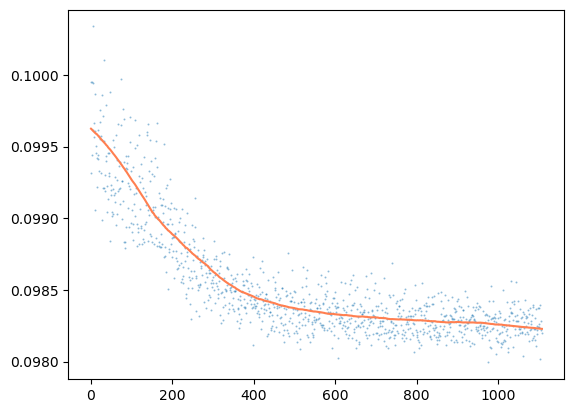

In [12]:
plot_loss(antipode_model.losses)

In [13]:
print(pyro.param('discov_mul'))

tensor([[1.0217],
        [1.0218],
        [1.0205]], device='cuda:0', grad_fn=<AddBackward0>)


In [14]:
antipode_model.store_outputs(device=device,prefix='')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


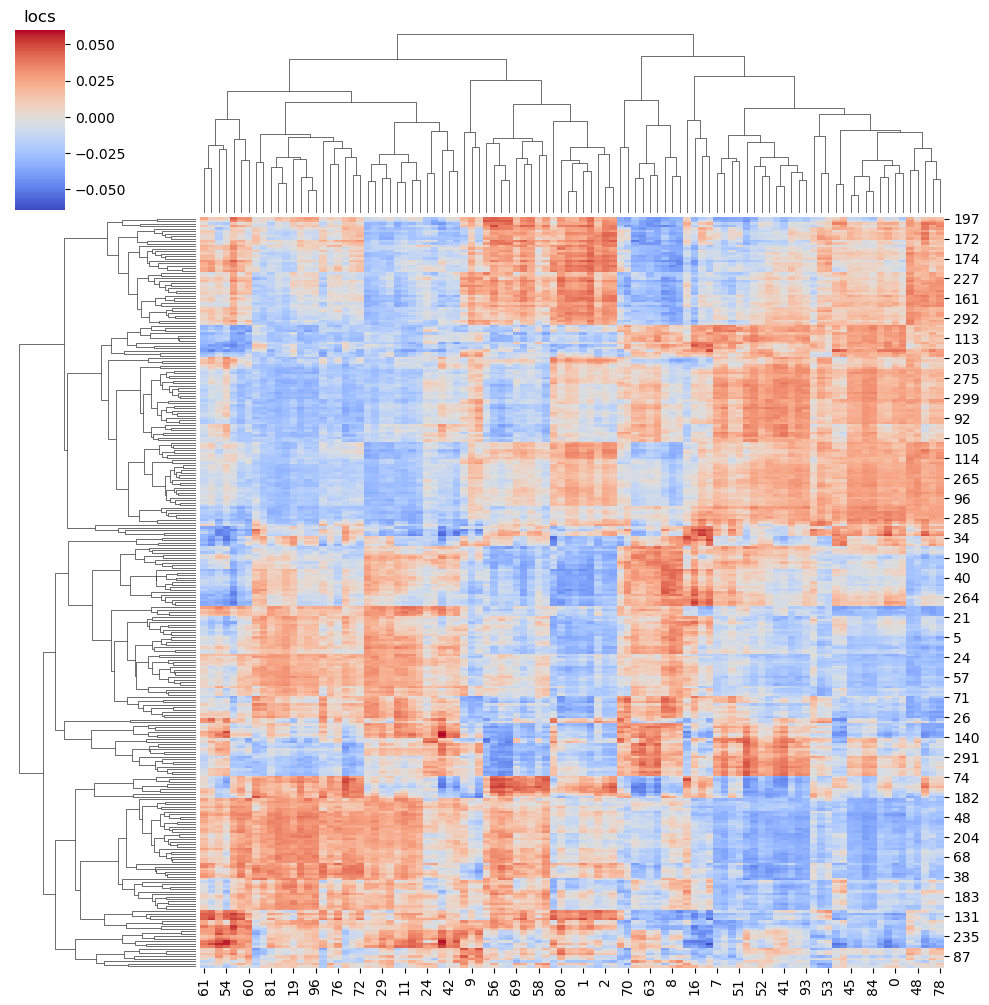

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


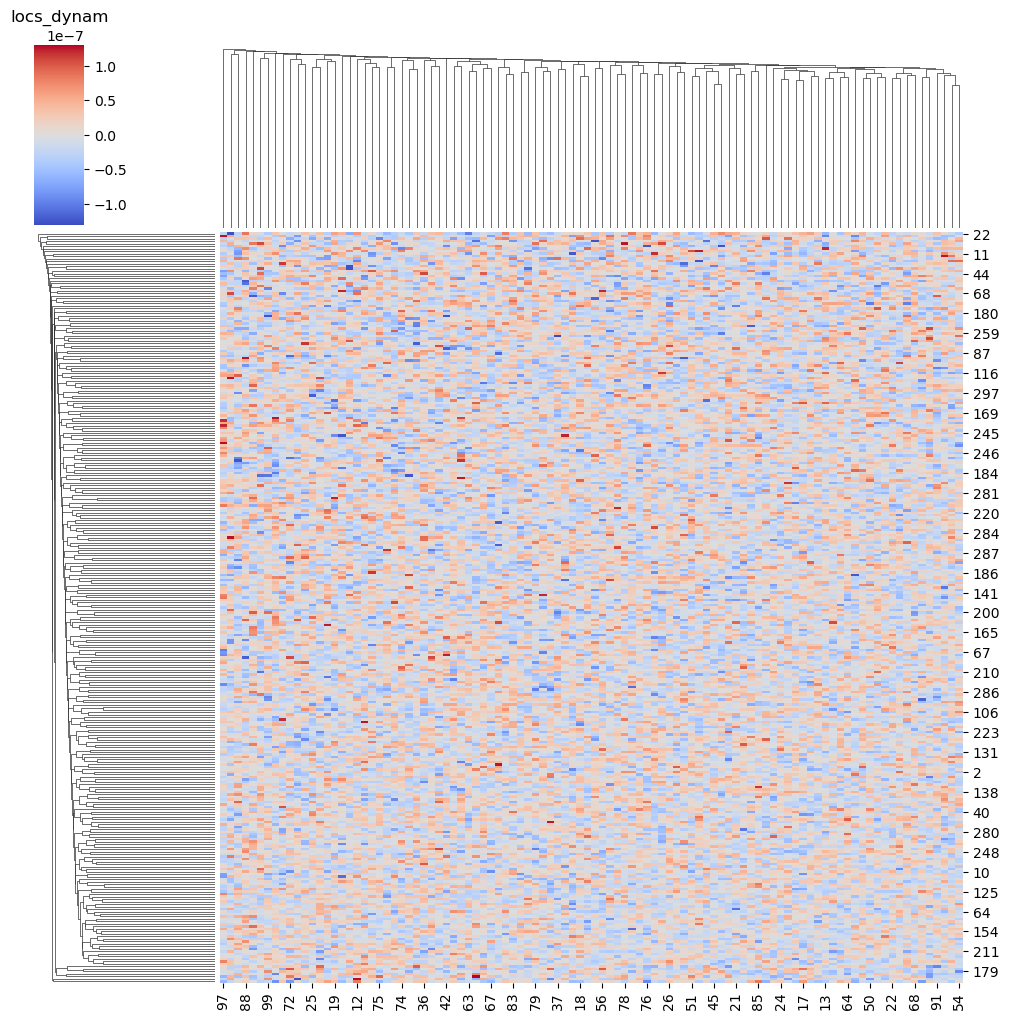

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


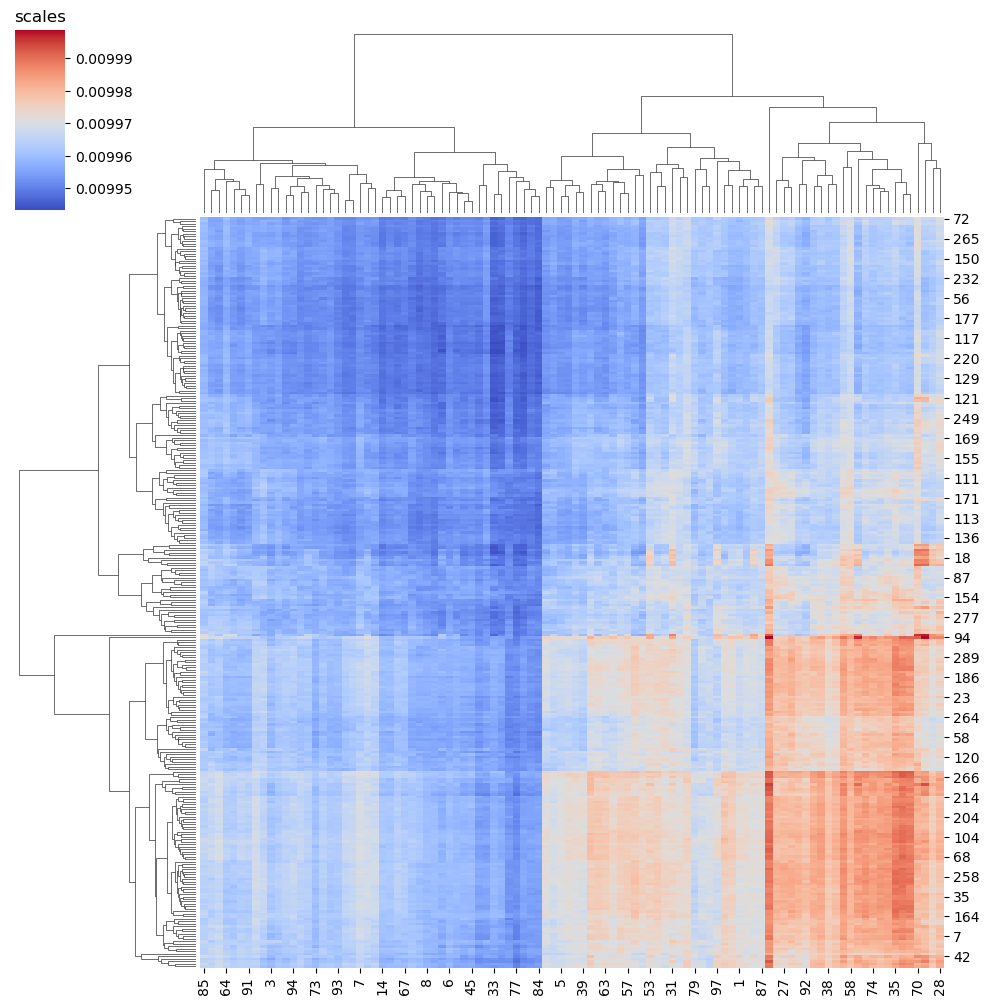

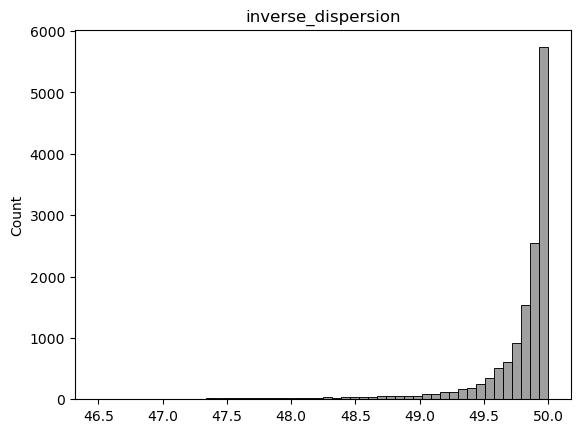

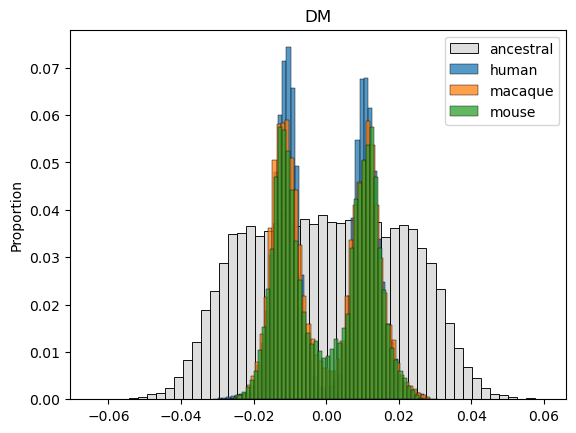

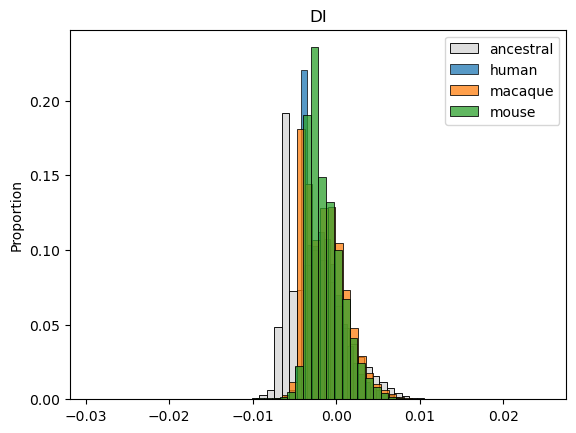

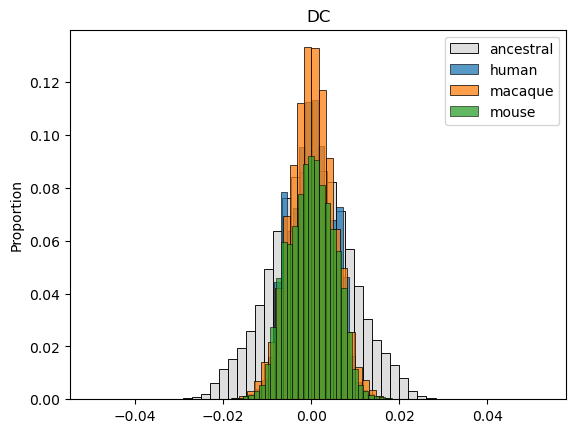

/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/plotting.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_species=antipode_model.adata_manager.adata.obs.groupby(antipode_model.batch_key)['species'].value_counts().unstack().idxmax(axis=1).to_dict()


,0,1,batch_name,species
0,-0.002034,-0.159301,CS12Diencephalon_kOut,human
1,0.017763,0.035663,CS12Hindbrain_kOut,human
2,0.257389,-0.131304,CS12Midbrain_kOut,human
3,1.564070,-0.840265,CS12OpticVesicle_kOut,human
4,1.215361,-0.393135,CS12SpinalCord_kOut,human
...,...,...,...,...
459,-0.533544,0.445030,p0-WT2,mouse
460,-0.939999,1.007382,p0-WT3,mouse
461,-0.427738,0.900268,p0-WT4,mouse
462,-0.053277,-0.185948,p07_Cortex_SRR11947654,mouse


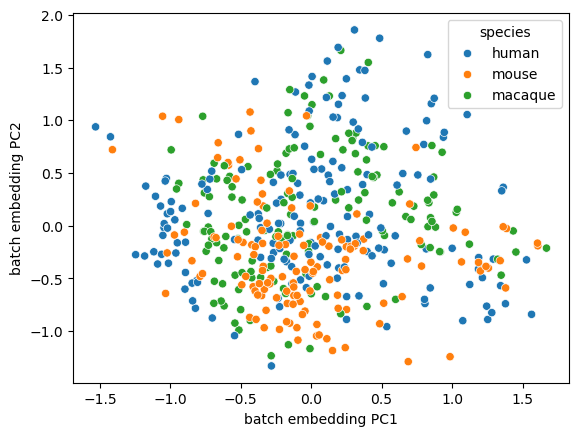

In [15]:
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_batch_embedding_pca(antipode_model)

In [16]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode'],init='random',accelerator='cpu'),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species",'batch_name'],palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["q_score"],
    cmap='coolwarm'
)


INFO     Using cpu for `pymde.preserve_neighbors`.                                                                 


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.11 /home/matthew.schmitz/Matthew/utils/miniforge3/e ...
  rank_zero_warn(


Mar 20 08:55:12 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Mar 20 08:55:12 PM: The following items have duplicates [ 14579  17974 175502 203362 208418 215491 227838]



KeyboardInterrupt



In [17]:
antipode_model.prepare_phase_2(epochs=1)
antipode_model.train_phase(phase=2,max_steps=max_steps,print_every=10000,num_particles=1,device=device, max_learning_rate=0.0005, one_cycle_lr=True, batch_size=64,freeze_encoder=True)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
Epoch [1/1], Loss: 5.1040



100%|██████████| 250/250 [00:00<00:00, 1855.00it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:218: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15261553/ipykernel_217250/2234096446.py:528: TracerWarni

KeyboardInterrupt: 

In [ ]:
!nvidia-smi

# Training Phase 2: Inintializing categorical layered tree

In [ ]:
antipode_model.prepare_phase_2(epochs=2,dimension_reduction='X_pca')#Pick D.R. of correct size

In [ ]:
antipode_model.train_phase(phase=2,max_steps=max_steps,print_every=10000,num_particles=1,device=device, max_learning_rate=0.002, one_cycle_lr=True, batch_size=64,freeze_encoder=False)

In [ ]:
plot_loss(antipode_model.losses)

In [ ]:
antipode_model.store_outputs(device=device,prefix='')

In [ ]:
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_tree_edge_weights(antipode_model)

In [ ]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode'],init='random'),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)

In [ ]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["psi"],
    cmap='coolwarm'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["q_score"],
    cmap='coolwarm'
)

In [ ]:
MDE_KEY = "X_antipode_MDE"
#adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode'],init='random'),0.1)
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_pca'],init='random'),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)


# Training Phase 3: Refining the final tree

In [37]:
antipode_model.train_phase(phase=3,max_steps=max_steps,print_every=10000,num_particles=7,device=device, max_learning_rate=1e-4, one_cycle_lr=True, steps=0, batch_size=64)

  0%|          | 1/10000 [00:00<1:06:08,  2.52it/s]/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:218: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15261553/ipykernel_217250/2234096446.py:528: TracerWarning: Converting a tensor to a Python boolean 

In [38]:
!nvidia-smi

Wed Mar 20 21:12:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:64:00.0 Off |                    0 |
| N/A   32C    P0              35W / 250W |  37921MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
pstore

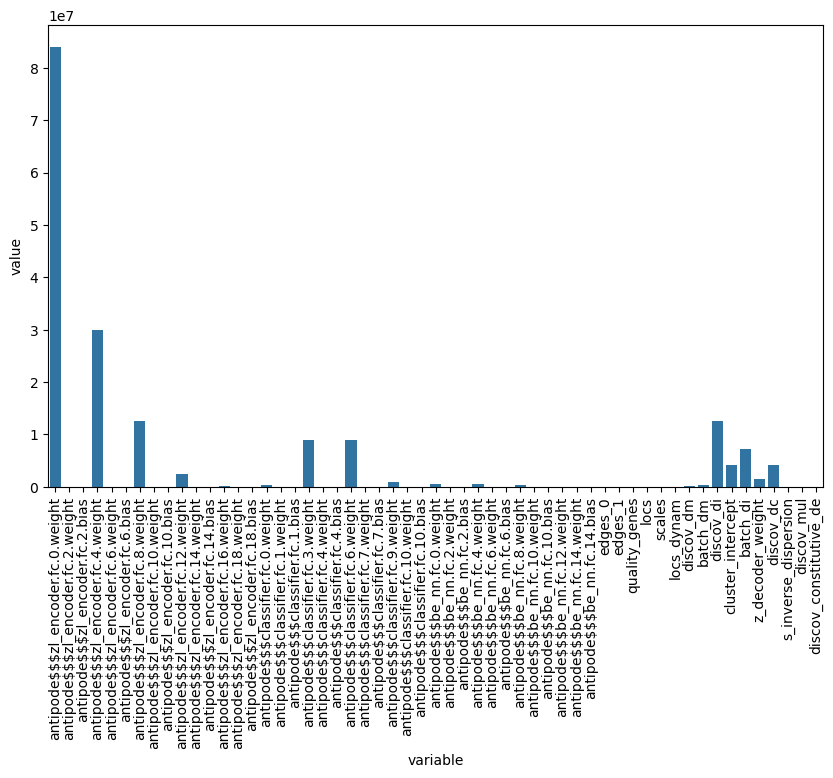

In [10]:
pstore=param_store_to_numpy()
import sys
d={}
for k in pstore.keys():
    d[k]=pstore[k].size

df=pd.DataFrame(d.values())
df.index=d.keys()
df_melted = df.T.melt(value_vars=df.index)
# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size to ensure labels don't overlap
seaborn.barplot(x='variable', y='value', data=df_melted)
plt.xticks(rotation=90)  # Rotate the labels if necessary
plt.show()


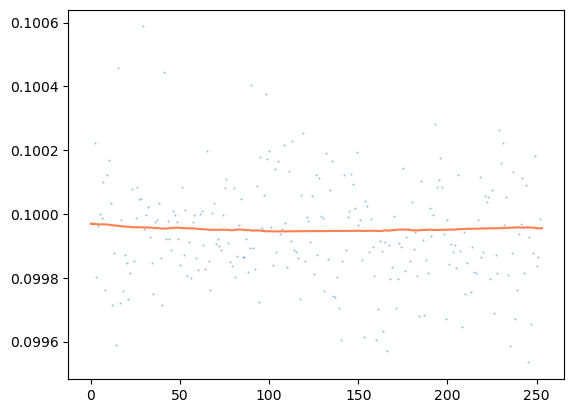

In [31]:
plot_loss(antipode_model.losses)

In [32]:
antipode_model.store_outputs(device=device,prefix='')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


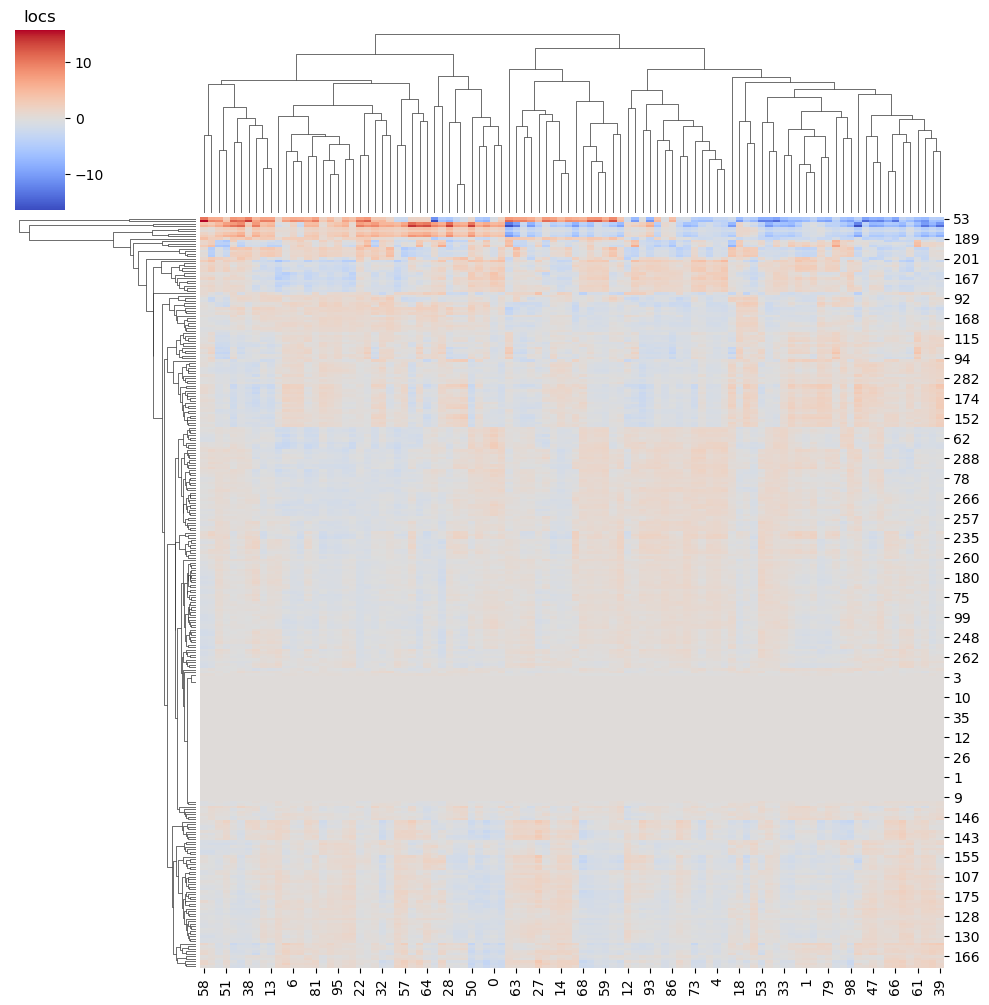

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


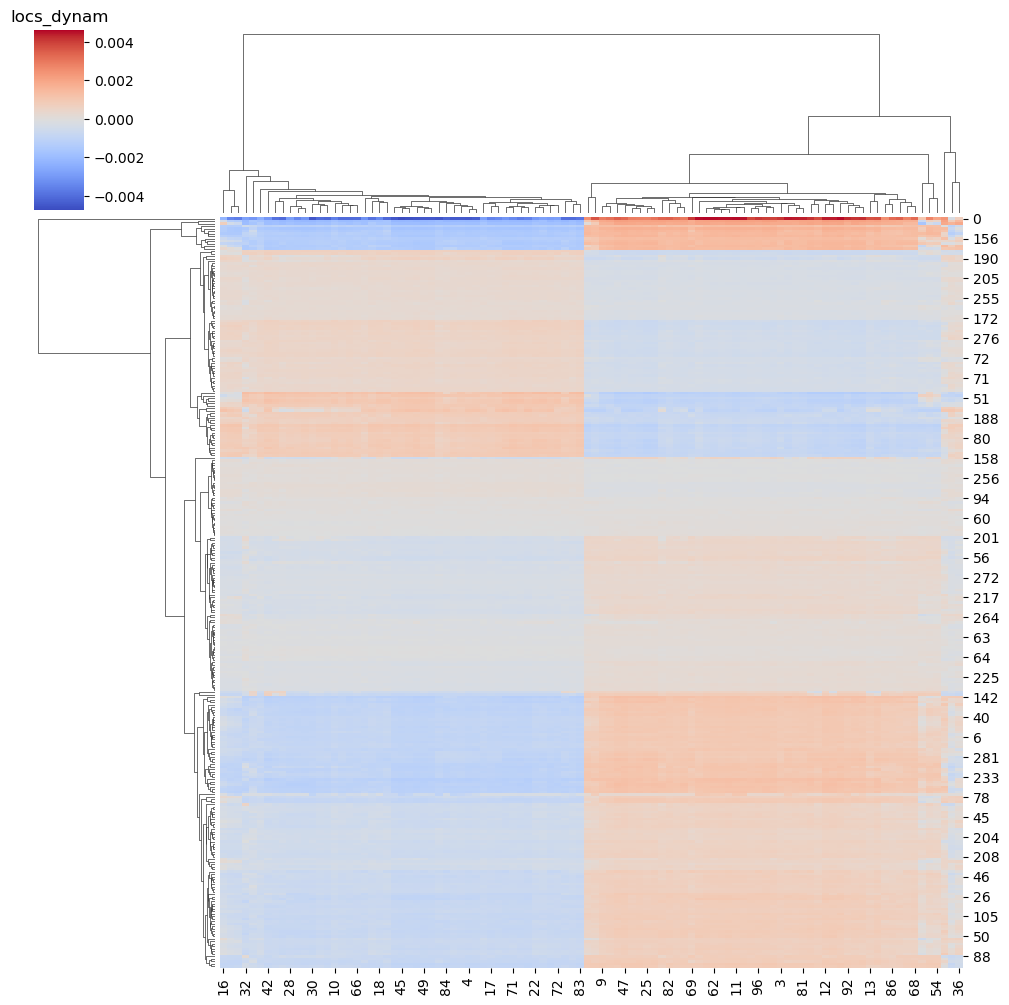

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


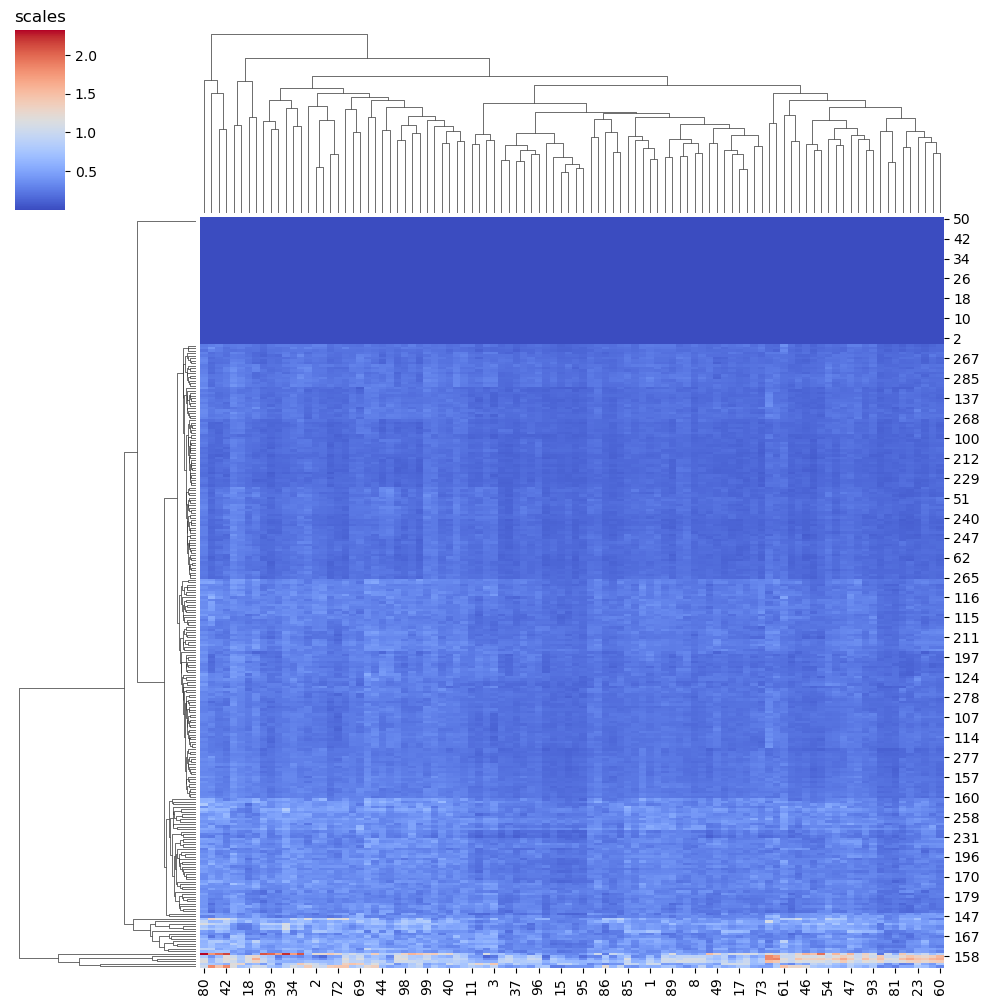

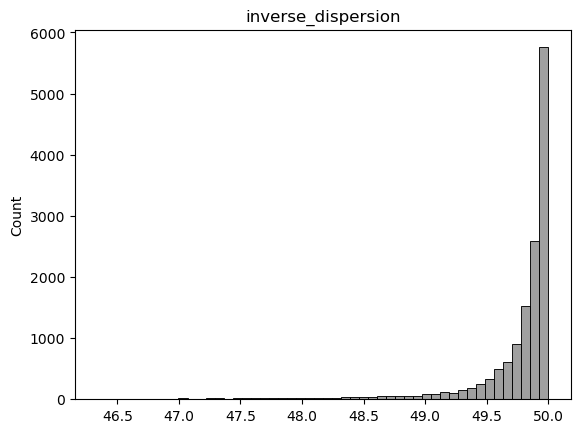

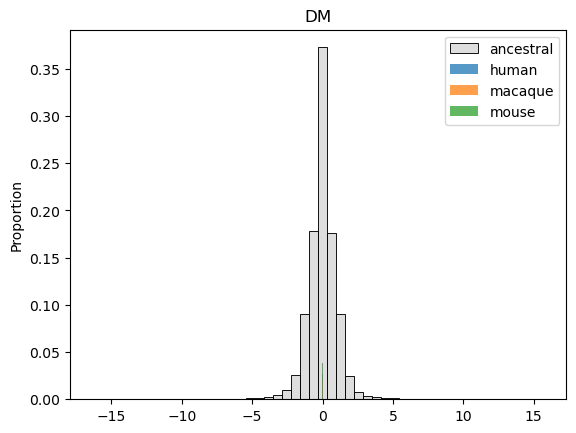

  4%|▎         | 363/10000 [11:06<4:54:45,  1.84s/it]


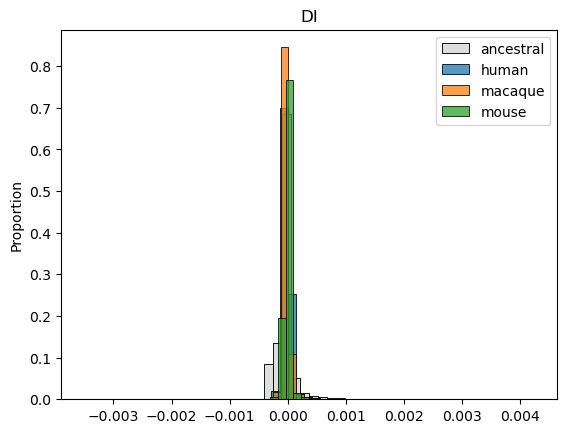

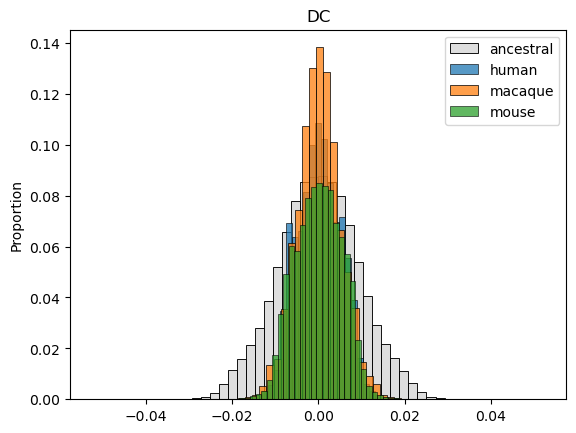

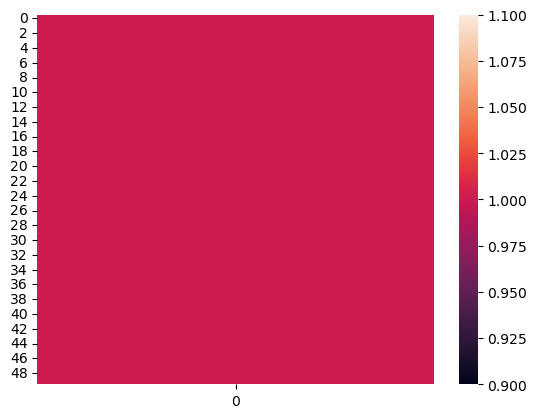

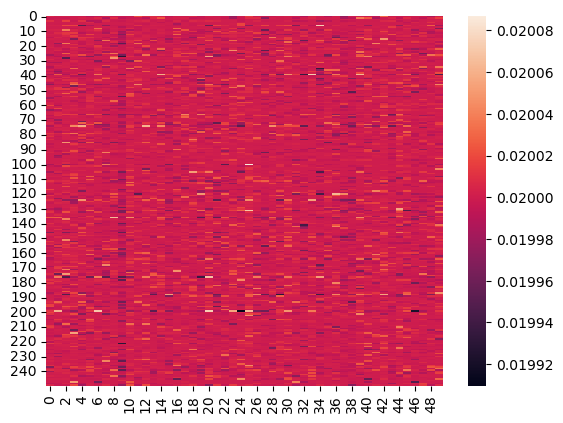

In [33]:
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_tree_edge_weights(antipode_model)

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.11 /home/matthew.schmitz/Matthew/utils/miniforge3/e ...
  rank_zero_warn(


Mar 20 09:07:44 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Mar 20 09:07:44 PM: The following items have duplicates [ 14579  16913  17974  62024  73877 164875 182788]


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


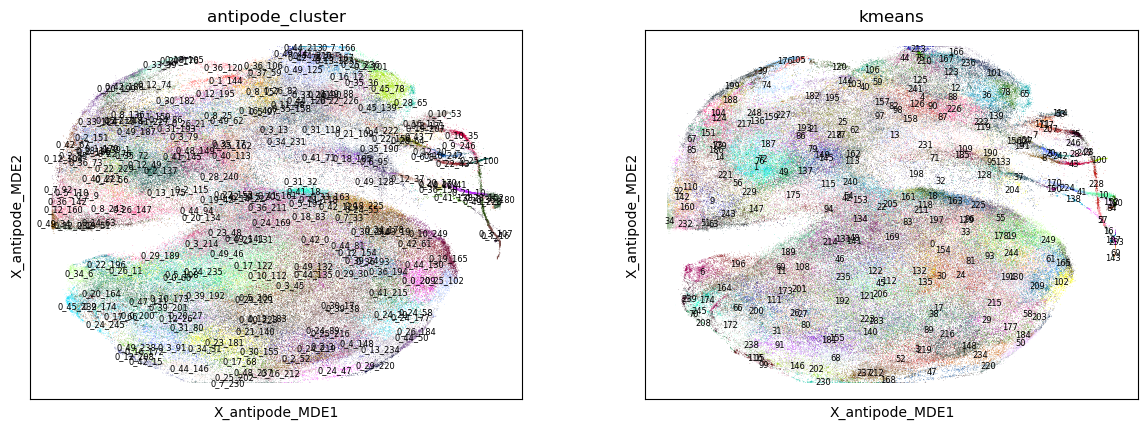

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


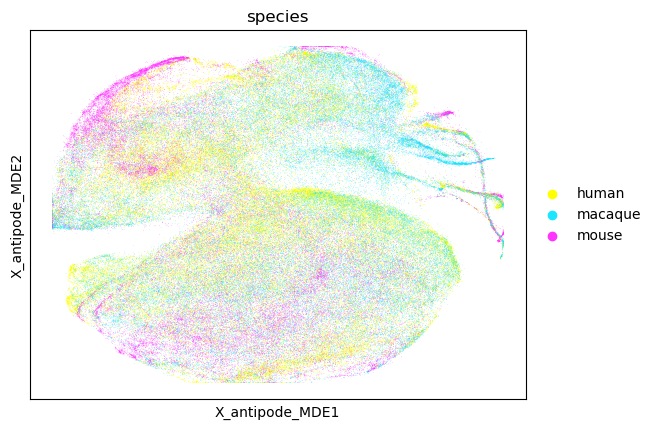

In [34]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode']),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)


In [36]:
!nvidia-smi

Wed Mar 20 21:09:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:64:00.0 Off |                    0 |
| N/A   28C    P0              34W / 250W |  30647MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["psi","q_score",'species'],
    cmap='coolwarm'
)


In [ ]:
seaborn.histplot(adata.obs['q_score'])

In [ ]:
seaborn.histplot(scipy.special.softmax( adata.uns['param_store']['edges_1'],-1).max(1))

In [ ]:
random_choice=np.random.choice(adata.obs.index,size=100000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()

In [ ]:
xdata.X=xdata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
#sc.pp.scale(xdata,max_value=10)

gene_list=['RBFOX3','PDGFRA','AQP4','FOXJ1','AIF1','MOG','COL1A2','CD34','COL4A1','SATB2','RORB','DLX2','PROX1','SCGN','TSHZ1','SLC17A7','TLE4','FEZF2',
           'MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','NPY','FOXP1','FOXP2','PDYN','PENK','ISL1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67','RPL7','RPS17','RPL13A','MEF2C']
gene_list=[x for x in gene_list if x in xdata.var.index]
sc.pl.embedding(
    xdata,
    basis=MDE_KEY,
    color=gene_list,cmap='Purples',
    palette=sc.pl.palettes.godsnot_102,legend_fontsize=6,
    legend_loc='on data',use_raw=False
)


In [ ]:
print(pyro.param('discov_mul'))


In [ ]:
xdata.X=xdata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]

In [ ]:
xdata.write_h5ad('/home/matthew.schmitz/Matthew/1.9.1.5_Dev.h5ad')

In [ ]:
#xdata=sc.read_h5ad('/home/matthew.schmitz/Matthew/1.9.4_devbigger.h5ad')